# Pre-class work

## Problem definition

In this session, we consider the following Gaussian mixture model.

* 70% of the data come from a normal distribution with mean 0 and standard deviation 4. We call this the background distribution since we know the mean and standard deviation.
* 30% of the data come from a normal distribution with unknown mean $\mu$ and standard deviation $\sigma$.
* This means the likelihood function given the data set, $\{x_i\}$, is a weighted sum (a mixture) of two normal distributions, with weights 0.7 and 0.3.
$$p(\{x_i\} \,|\, \mu, \sigma) = \prod_{i=1}^n\left[ 0.7\,\text{Normal}(x_i \,|\, 0, 4^2) + 0.3\,\text{Normal}(x_i \,|\, \mu, \sigma^2) \right]$$
* We are told that $\mu$ and $\sigma$ are not too different from the background normal distribution, and we have the following priors over them:
  * $\mu \sim \text{Normal}(0, 5^2)$
  * $\sigma \sim \text{Gamma}(2, 1)$

Below is a data set for the model above. About 70% of these data were generated from $\text{Normal}(0, 4^2)$ and about 30% from $\text{Normal}(\mu, \sigma^2)$. We are interested in the posterior over $\mu$ and $\sigma$.

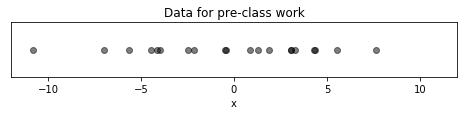

In [6]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

data = np.array([
    -4.127935, -2.152332, 3.046302, -10.77442, -6.985155, 5.536106, 1.294746,
    7.638998, -5.650118, -4.478067, -0.4551435, -3.969413, -0.4225518,
    -2.462094, 1.886675, 3.095567, 4.310003, 3.305034, 0.8548273, 4.368213])

plt.figure(figsize=(8, 1))
plt.plot(data, [0.05] * len(data), 'ko', alpha=0.5)
plt.xlabel('x')
plt.xticks([-10, -5, 0, 5, 10])
plt.yticks([])
plt.xlim(-12, 12)
plt.title('Data for pre-class work')
plt.show()

Essentially the problem is that we don’t know which of these data were generated from the background distribution, of which we know the mean and variance, and which data were generated from another normal distribution with an unknown mean and variance.

To get a better sense of how difficult it is to determine the normal with unknown mean and variance, the plot below shows the data along with the background distribution. The background distribution seems to account for the data set fairly well. Which data points might have been generated by another normal distribution?

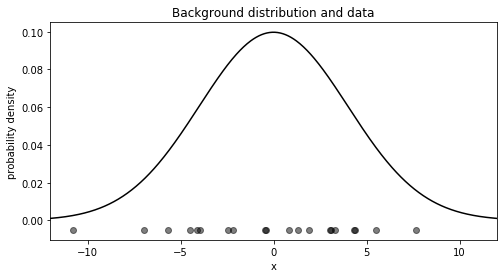

In [7]:
# Plot of the background normal distribution and the data. This shows what we
# know about the model. What we don't know is the other normal distribution.

plot_mu_range = [-12, 12]
plot_sigma_range = [0, 4]
plt.figure(figsize=(8, 4))
plot_x = np.linspace(plot_mu_range[0], plot_mu_range[1], 500)
plot_y = sts.norm.pdf(plot_x, loc=0, scale=4)
plt.plot(plot_x, plot_y, 'k-')
plt.plot(data, [-0.005] * len(data), 'ko', alpha=0.5)
plt.xlim(-12, 12)
plt.xlabel('x')
plt.ylabel('probability density')
plt.xticks([-10, -5, 0, 5, 10])
plt.title('Background distribution and data')
plt.show()

### Question

Looking at the plot of the data above, and knowing that about 70% of the data were generated from the background distribution (mean = 0, standard deviation = 4), what is your best guess for what $\mu$ and $\sigma$ are? Which data were generated from the background normal distribution and which were generated from the unknown normal distribution?

In [8]:
# ANSWER: 
# mu and sigma are probably -0.5 (dense middle dot) and 3
# The outlier data are from background, some of the data inside [-5, 5] are from the unknown normal

## Posterior distribution

The posterior over $\mu$ and $\sigma$ is proportional to the product of the likelihood and the prior.
$$p(\mu, \sigma\,|\,\{x_i\}) \propto \text{Normal}(\mu\,|\,0, 5^2) \,\text{Gamma}(\sigma\,|\,2, 1) \prod_{i=1}^{20} \left[0.7\,\text{Normal}(x_i\,|\,0,4^2) + 0.3\,\text{Normal}(x_i\,|\,\mu,\sigma^2)\right]$$

### Question

Why is it difficult to compute the normalization constant of this posterior distribution?

In [9]:
# ANSWER:
# we would have to integrate over the pdf of mu and sigma to find it

## Plot of unnormalized posterior distribution

Below is the unnormalized posterior pdf function in Python, along with a 2-d contour plot of the pdf.

How does the posterior over $\mu$ and $\sigma$ compare to your best guess for what $\mu$ and $\sigma$ are?

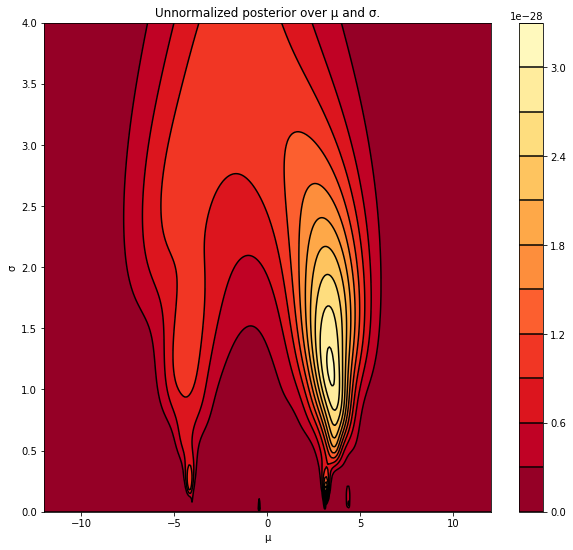

In [10]:
def unnormalized_posterior(mu, sigma, data):
    '''
    The unnormalized posterior pdf over μ and σ. The pdf depends on the
    parameters, `mu` and `sigma`, as well as the `data`.
    '''
    if sigma <= 0:
        # The probability of sigma <= 0 is 0. It will become clear why we need
        # need this check a little further down, when we generate samples from
        # a proposal distribution (not the posterior), which might give values
        # of sigma <= 0.
        return 0

    else:
        return (
            sts.gamma.pdf(sigma, a=2, scale=1) *
            sts.norm.pdf(mu, loc=0, scale=5) *
            np.prod(
                0.7 * sts.norm.pdf(data, loc=0, scale=4) +
                0.3 * sts.norm.pdf(data, loc=mu, scale=sigma)))


# Plot of the unormalized posterior using a 2-d contour plot.
mu = np.linspace(plot_mu_range[0], plot_mu_range[1], 300)
sigma = np.linspace(plot_sigma_range[0], plot_sigma_range[1], 300)
posterior = np.empty((len(sigma), len(mu)))
for i in range(len(sigma)):
    for j in range(len(mu)):
        posterior[i,j] = unnormalized_posterior(mu[j], sigma[i], data)

plt.figure(figsize=(10, 9))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.title('Unnormalized posterior over μ and σ.')
plt.xlabel('μ')
plt.ylabel('σ')
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()

## Tasks

**Task 1:** Select a proposal distribution for doing importance sampling. Below is an example of a **bad** proposal distribution. Think of a better one and use it to generate samples of mu and sigma.

Remember that a good proposal distribution should have a lot of probability mass at similar locations to where the true posterior distribution has lots of probability mass.

* Write the code for your proposal distribution in the `good_proposal_rvs` function below.
* Update the plot to show samples from your proposal distribution on the posterior pdf.

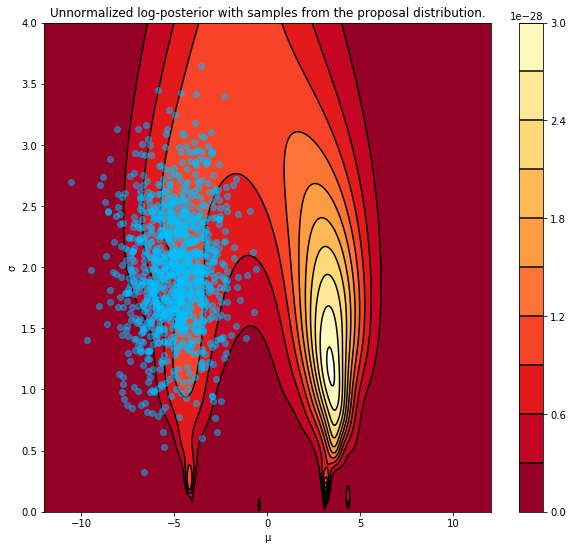

In [6]:
def bad_proposal_rvs(size):
    return {
        'mu': sts.norm.rvs(loc=-5, scale=1.5, size=num_samples),
        'sigma': sts.norm.rvs(loc=2, scale=0.5, size=num_samples)}


def good_proposal_rvs(size):
    return {
        'mu': ...,
        'sigma': ...}


# Generate samples
num_samples = 10000

# The bad proposal distribution is a product of independent normal distributions
# over mu and sigma with means [-5, 1.5] and standard deviations [2, 0.5].
samples = bad_proposal_rvs(num_samples)

# Plot of the first 1000 samples on the level plot
plt.figure(figsize=(10, 9))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.plot(samples['mu'][:1000], samples['sigma'][:1000], 'o', color='#00c0ff', alpha=0.5)
plt.title('Unnormalized log-posterior with samples from the proposal distribution.')
plt.xlabel('μ')
plt.ylabel('σ')
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()

## Task 2
Once you have your samples, use them to approximate the following—

* The mean and standard deviation of $\mu$.
* The mean and standard deviation of $\sigma$.

Note that you can use the same samples to calculate all four of these values. You do not have to generate new samples every time.

You will have to enter the pdf of your proposal distribution below to calculate the importance weights. Note how the `bad_proposal_pdf` function below matches the `bad_proposal_rvs` function above. You you should similarly make `good_proposal_pdf` match `good_proposal_rvs`.

In [ ]:
# TASK: Write the pdf of your proposal distribution in this function.

def bad_proposal_pdf(mu, sigma):
    return (
        sts.norm.pdf(mu, loc=-5, scale=1.5) * 
        sts.norm.pdf(sigma, loc=2, scale=0.5))


def good_proposal_pdf(mu, sigma):
    return ...


# Calculate the importance weights, p(sample) / q(sample). You need the
# importance weights to compute expected values under the target distribution.
importance_weights = np.empty(num_samples)
for i in range(num_samples):
    p_value = unnormalized_posterior(samples['mu'][i], samples['sigma'][i], data)
    q_value = good_proposal_pdf(samples['mu'][i], samples['sigma'][i])
    importance_weights[i] = p_value / q_value

In [ ]:
# TASK: Approximate the mean and standard deviation of mu and sigma using
# mu_samples, sigma_samples, and the importance weights calculated above.
